## Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import dsa
from dsa import *
from datasets import image
from models import resnet
import pickle

## Hardware allocation strategy

In [2]:
# limit tf to use the first gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


2022-02-25 05:01:55.355331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-25 05:01:56.133180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10543 MB memory:  -> device: 0, name: TITAN V, pci bus id: 0000:3b:00.0, compute capability: 7.0


## Load dataset: `cifar-10`

In [3]:
target_ds, aux_ds = image.load_cifar10()

## Attack with different split layers

In [4]:
cifar10_dsa = {}
log = {}

for split in [2,3,4]:
    make_f, make_g, make_e, make_d, make_c = resnet.make_resnet(split=split, class_num=10)
    cifar10_dsa["cifar10-split="+str(split)] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log["cifar10-split="+str(split)] = cifar10_dsa["cifar10-split="+str(split)].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        batch_size=64,
        iterations=5000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.0001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.0001,
        lr_c=0.0001,
        iter_d=50,   # the number of iterations to train the decoder on auxiliary data
        w=500.,
        verbose=True,
        log_freq=200)

# with open('log/cifar10.pkl', 'wb') as f:
    # pickle.dump(log, f)

======Split level is 2======


2022-02-25 05:03:40.528570: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


Iteration 200, average attack MSE: 0.23079649731516838
Iteration 400, average attack MSE: 0.09388597398996353
Iteration 600, average attack MSE: 0.029857922131195664
Iteration 800, average attack MSE: 0.019991539465263487
Iteration 1000, average attack MSE: 0.018428917741402984
Iteration 1200, average attack MSE: 0.017575491070747375
Iteration 1400, average attack MSE: 0.01654443924780935
Iteration 1600, average attack MSE: 0.015941677889786662
Iteration 1800, average attack MSE: 0.01557315059006214
Iteration 2000, average attack MSE: 0.015129051599651576
Iteration 2200, average attack MSE: 0.01492540206760168
Iteration 2400, average attack MSE: 0.014492117683403194
Iteration 2600, average attack MSE: 0.014467304334975778
Iteration 2800, average attack MSE: 0.014242643839679658
Iteration 3000, average attack MSE: 0.01405846425332129
Iteration 3200, average attack MSE: 0.013962797774001955
Iteration 3400, average attack MSE: 0.01388315625488758
Iteration 3600, average attack MSE: 0.0136

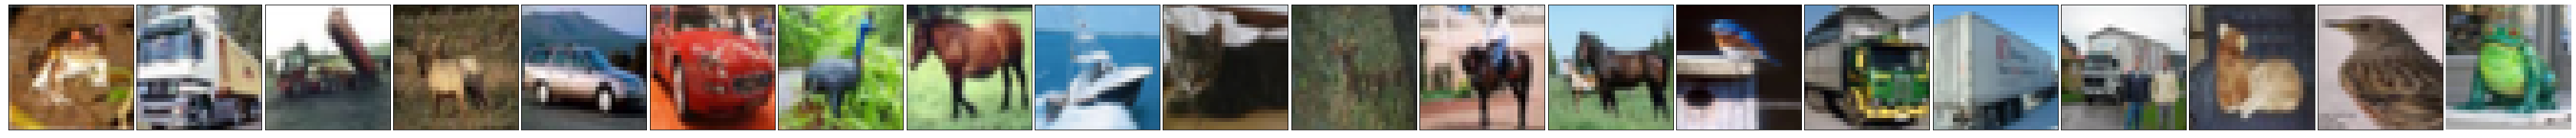

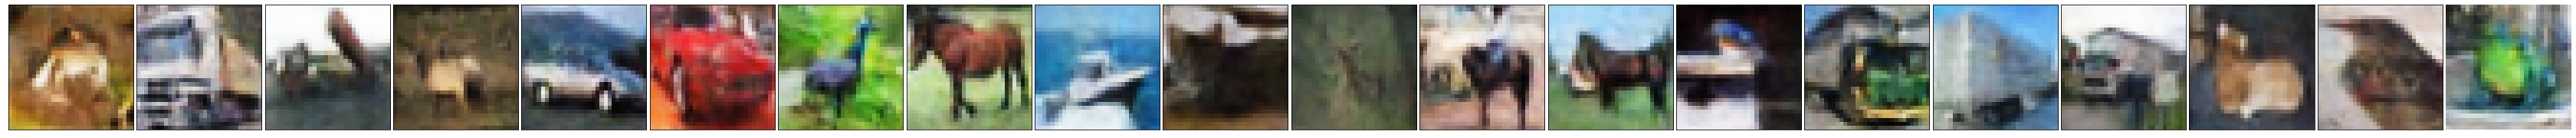

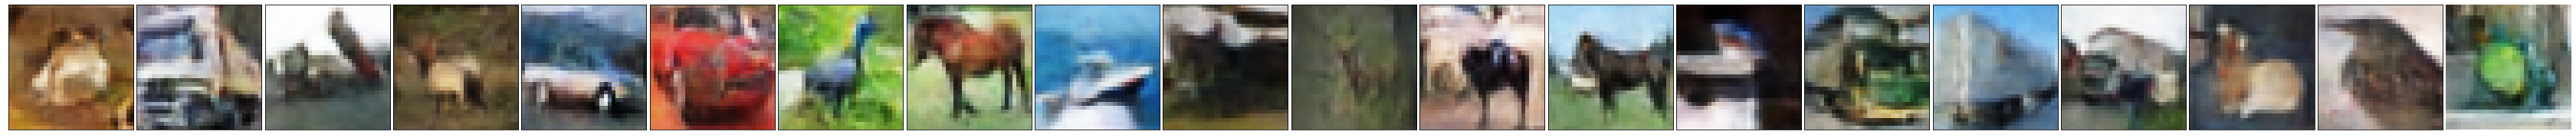

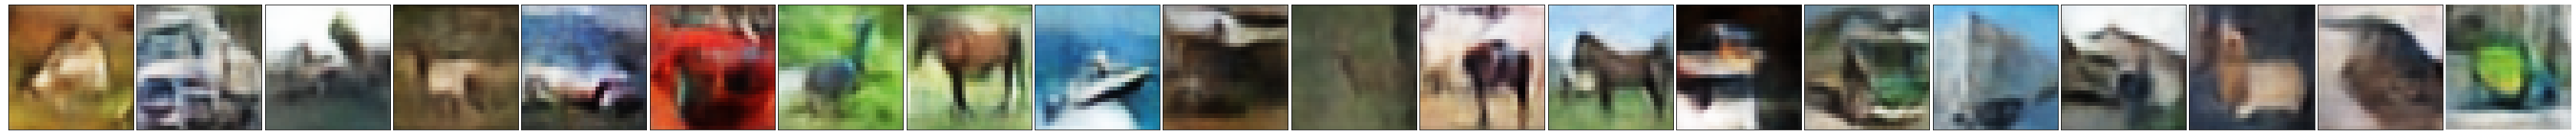

In [8]:
imgs = image.load_cifar10(take_first=20)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno')
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
    return fig

fig = plot(imgs)
for split in [2,3,4]:
    _, rec_res = cifar10_dsa["cifar10-split="+str(split)].attack_examples(imgs)
    fig = plot(rec_res)

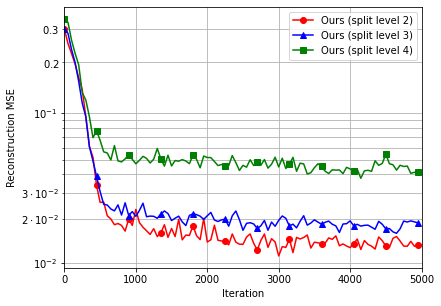

In [81]:
with open('log/cifar10.pkl', 'rb') as f:
    log = pickle.load(f)

from matplotlib.pyplot import figure
figure(figsize=(6.4,4.8))
log_freq = 50
plt.yscale('logit')
plt.xlim([0,5000])
plt.grid("both", "both")
sampled_log_2 = [log["cifar10-split=2"][:,1][i*log_freq] for i in range(int(len(log["cifar10-split=2"][:,0])/log_freq))]
sampled_log_3 = [log["cifar10-split=3"][:,1][i*log_freq] for i in range(int(len(log["cifar10-split=3"][:,0])/log_freq))]
sampled_log_4 = [log["cifar10-split=4"][:,1][i*log_freq] for i in range(int(len(log["cifar10-split=4"][:,0])/log_freq))]
ran = [i * log_freq for i in range(int(5000/log_freq))]
plt.plot(ran, sampled_log_2, 'ro-', ran, sampled_log_3, 'b^-', ran, sampled_log_4, 'gs-', markevery=9)
plt.ylabel('Reconstruction MSE')
plt.xlabel('Iteration')
plt.legend(["Ours (split level 2)", "Ours (split level 3)", "Ours (split level 4)"])
plt.savefig("fig/cifar10-all.pdf", bbox_inches='tight')

Seems all right!